# Práctica 10: AEs

En esta práctica usaremos un autoencoder como detector de anomalías. Para ello entrenaremos un autoenconder con un conjunto de imágenes de radiografias de tórax de individuos sanos y consideraremos como anomalías las radiografías de individuos con neumonía

In [1]:
!pip install torch numpy matplotlib scikit-image cython setuptools medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 7.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 37.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.0 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=

In [2]:
### EVITAR ERRORES

!uv pip install -q --system numba-cuda==0.4.0

from numba import config
config.CUDA_ENABLE_PYNVJITLINK = 1

In [3]:
import numpy as np
print(np.__version__)

2.0.2


## Dataset

Usaremos un subconjunto de [__MedMNIST__](https://medmnist.com/): un dataset con diversos conjuntos de datos de imágenes médicas. En concreto usaremos __PneumoniaMNIST__, que tiene las siguientes características:
- Más de 5000 imágenes divididas en conjuntos de training, validation y testing.
- Imágenes monocromas de 28x28 píxeles
- Directamente utilizable desde pytorch
- Cada imagen tiene una etiqueta asociada que indica si la imagen es de un individuo sano o con neumonía.

Para poder utilizar el dataset, primero deberemos instalar el paquete medmnist: ``pip install medmnist``

A continuación se incluye un código python que permite un acceso básico al dataset y muestra mosaicos de imágenes de individuos sanos y con neumonía.

In [4]:
import medmnist
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset, Subset
import matplotlib.pyplot as plt
from collections import Counter
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns


print(medmnist.__version__)
from medmnist import PneumoniaMNIST

3.0.2


In [5]:
# Información del dataset
download = True
info = medmnist.INFO['pneumoniamnist']
print(info)

# Obtener la clase de datos
DataClass = getattr(medmnist, info['python_class'])

# Transformaciones de imagen
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Cargar dataset
train_dataset = DataClass(split='train', transform=transform, download=download)

healthy_images = []
pneumonia_images = []

for img, label in train_dataset:
    if label.item() == 0:
        healthy_images.append(img.squeeze())  # quitar dimensión del canal
    if len(healthy_images) == 12:
        break

for img, label in train_dataset:
    if label.item() == 1:
        pneumonia_images.append(img.squeeze())
    if len(pneumonia_images) == 12:
        break

{'python_class': 'PneumoniaMNIST', 'description': 'The PneumoniaMNIST is based on a prior dataset of 5,856 pediatric chest X-Ray images. The task is binary-class classification of pneumonia against normal. We split the source training set with a ratio of 9:1 into training and validation set and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−2,916)×(127−2,713). We center-crop the images and resize them into 1×28×28.', 'url': 'https://zenodo.org/records/10519652/files/pneumoniamnist.npz?download=1', 'MD5': '28209eda62fecd6e6a2d98b1501bb15f', 'url_64': 'https://zenodo.org/records/10519652/files/pneumoniamnist_64.npz?download=1', 'MD5_64': '8f4eceb4ccffa70c672198ea285246c6', 'url_128': 'https://zenodo.org/records/10519652/files/pneumoniamnist_128.npz?download=1', 'MD5_128': '05b46931834c231683c68f40c47b2971', 'url_224': 'https://zenodo.org/records/10519652/files/pneumoniamnist_224.npz?download=1', 'MD5_224': 'd6a3c71de1b945ea11211b

100%|██████████| 4.17M/4.17M [00:06<00:00, 615kB/s]


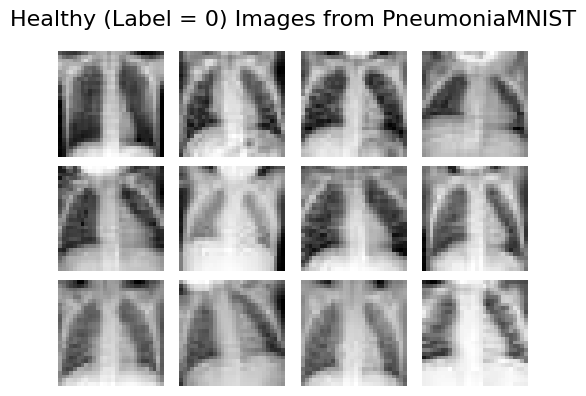

In [6]:
# Crear mosaico de imágenes sanas
fig, axes = plt.subplots(3, 4, figsize=(5, 4))
fig.suptitle("Healthy (Label = 0) Images from PneumoniaMNIST", fontsize=16)
for i, ax in enumerate(axes.flat):
    ax.imshow(healthy_images[i], cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()

Obsérvese que el dataset estará compuesto de todas las imágenes, y que para distinguirlas habrá que hacer uso de la etiqueta asociada a cada imagen.

## Modelo

Se probarán las prestaciones de modelos autoencoders estándar (AE) y variacionales (VAE). Como punto de partida se propone la estructura propuesta en el paper disponible en el siguiente [enlace](https://essay.utwente.nl/98159/1/Reve_BA_EEMCS.pdf)

Obsérvese en la fig. 6 del paper la estructura del autoencoder utilizado, en la cual el _bottleneck_ es de tamaño 4x4x8 = 128 sin aplanar

## Tareas a realizar en la práctica



### **1. Estudiar las características del dataset y plantear un marco experimental adecuado: entrenar con las imágenes del conjunto de training de individuos sanos y usar un conjunto de validación y otro de test balanceados (mismo número de imágenes de individuos sanos y con neumonía)**

🎯 Objetivo: Entrenar un modelo con datos solo de personas sanas (label = 0), para que luego podamos ver si detecta las imágenes "raras", es decir, con neumonía (label = 1).

Esto se parece a lo que se llama un sistema de detección de anomalías, o más formalmente: one-class classification.

✅ Entrenamiento:
Solo usaremos las imágenes de entrenamiento con label = 0.

🔄 Validación y test:
Usaremos conjuntos balanceados: igual número de imágenes sanas y con neumonía, para ver cómo el modelo se comporta con ambos tipos.

#### **Características** del dataset `PneumoniaMNIST`

In [7]:
# Función para mostrar info
def show_info(nombre, dataset):
    labels = [label.item() for _, label in dataset]
    class_counts = Counter(labels)
    print(f"\n--- {nombre.upper()} ---")
    for k, v in class_counts.items():
        print(f"Clase {k}: {v} imágenes")
    sample_img, _ = dataset[0]
    print(f"Tamaño de imagen: {sample_img.shape}")

In [8]:
# Inicializa datasets
train_dataset = PneumoniaMNIST(split='train', transform=transform, download=True)
val_dataset   = PneumoniaMNIST(split='val', transform=transform, download=True)
test_dataset  = PneumoniaMNIST(split='test', transform=transform, download=True)

# Mostrar info para cada split
show_info("Train", train_dataset)
show_info("Validation", val_dataset)
show_info("Test", test_dataset)


--- TRAIN ---
Clase 1: 3494 imágenes
Clase 0: 1214 imágenes
Tamaño de imagen: torch.Size([1, 28, 28])

--- VALIDATION ---
Clase 1: 389 imágenes
Clase 0: 135 imágenes
Tamaño de imagen: torch.Size([1, 28, 28])

--- TEST ---
Clase 1: 390 imágenes
Clase 0: 234 imágenes
Tamaño de imagen: torch.Size([1, 28, 28])


Este dataset contiene imágenes médicas (radiografías torácicas) preprocesadas y etiquetadas como:

* 0: Sano

* 1: Con neumonía

Son imágenes en escala de grises (1 canal) y tamaño fijo: 28x28 píxeles.


#### Definir **autoencoder simple**

In [9]:

class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()

        # Encoder más relajado, pero con algo de capacidad
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),  # [B, 16, 14, 14]
            nn.ReLU(),
            nn.Conv2d(16, 8, kernel_size=3, stride=2, padding=1),  # [B, 8, 7, 7]
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Conv2d(8, 4, kernel_size=3, stride=2, padding=1),   # [B, 4, 4, 4]
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(4, 8, kernel_size=2, stride=2),     # [B, 8, 8, 8]
            nn.ReLU(),
            nn.ConvTranspose2d(8, 8, kernel_size=2, stride=2),     # [B, 8, 16, 16]
            nn.ReLU(),
            nn.ConvTranspose2d(8, 16, kernel_size=2, stride=2),    # [B, 16, 32, 32]
            nn.ReLU(),
            nn.Conv2d(16, 1, kernel_size=3, padding=1),            # [B, 1, 32, 32]
            nn.Upsample(size=(28, 28), mode='bilinear'),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


#### **Entrenar** autoencoder

In [10]:
### ENTRENAMIENTO SOLO CON IMÁGENES SANAS
# Obtener imágenes sanas (label == 0)
healthy_images = [img for img, label in train_dataset if label.item() == 0]
healthy_tensor = torch.stack(healthy_images)

# Dataset y dataloader
healthy_dataset = TensorDataset(healthy_tensor)
train_loader = DataLoader(healthy_dataset, batch_size=64, shuffle=True)


#### Creamos **conjuntos balanceados** de val y test

In [11]:
# Función que produce datasets balanceados
def get_balanced_subset(dataset):
    labels = [label.item() for _, label in dataset]
    class_counts = Counter(labels)
    current_min = -1
    for k, v in class_counts.items():
        if current_min == -1:
            current_min = v
        else:
            current_min = min(current_min, v)

    n = current_min

    healthy = [ (img, label) for img, label in dataset if label.item() == 0 ][:n]
    pneumonia = [ (img, label) for img, label in dataset if label.item() == 1 ][:n]

    return healthy + pneumonia, n

balanced_val, n_val = get_balanced_subset(val_dataset)
balanced_test, n_test = get_balanced_subset(test_dataset)

print(f"Subconjunto validación: {len(balanced_val)} imágenes ({n_val} sanos + {n_val} con neumonía)")
print(f"Subconjunto test: {len(balanced_test)} imágenes ({n_test} sanos + {n_test} con neumonía)")


Subconjunto validación: 270 imágenes (135 sanos + 135 con neumonía)
Subconjunto test: 468 imágenes (234 sanos + 234 con neumonía)


#### Transformar a **`TensorDataset`** (evita errores)

In [12]:
# Función para pasar de lista de tuplas a TensorDataset
def list_to_tensor_dataset(data_list):
    imgs = torch.stack([img for img, _ in data_list])
    labels = torch.tensor([label for _, label in data_list])
    return TensorDataset(imgs, labels)


#### **Preparación** autoencoder

In [13]:
## DATOS
# Dataset de entrenamiento con solo imágenes sanas
healthy_train_indices = [i for i, (_, label) in enumerate(train_dataset) if label.item() == 0]
healthy_train_subset = Subset(train_dataset, healthy_train_indices)
train_loader = DataLoader(healthy_train_subset, batch_size=64, shuffle=True)

# Arreglar val y test
val_dataset_bal = list_to_tensor_dataset(balanced_val)
test_dataset_bal = list_to_tensor_dataset(balanced_test)

# Loaders correctos
val_loader = DataLoader(val_dataset_bal, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset_bal, batch_size=64, shuffle=False)


## MODELO
# Autoencoder
autoencoder = Autoencoder()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
autoencoder.to(device)

# Función de pérdida y optimizador
criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)

<ipython-input-12-48cbd20e1bb7>:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  labels = torch.tensor([label for _, label in data_list])


#### **Entrenamiento** autoencoder

In [14]:
### TRAIN
num_epochs = 200

for epoch in range(num_epochs):
    # ENTRENAMIENTO
    autoencoder.train()
    train_loss = 0.0
    for imgs, _ in train_loader:
        imgs = imgs.to(device)

        # Forward
        outputs = autoencoder(imgs)
        loss = criterion(outputs, imgs)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * imgs.size(0)

    train_loss /= len(train_loader.dataset)

    # VALIDACIÓN
    autoencoder.eval()
    val_loss = 0.0
    with torch.no_grad():
        for imgs, _ in val_loader:
            imgs = imgs.to(device)
            outputs = autoencoder(imgs)
            loss = criterion(outputs, imgs)
            val_loss += loss.item() * imgs.size(0)

    val_loss /= len(val_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


Epoch [1/200], Train Loss: 0.1450, Val Loss: 0.1234
Epoch [2/200], Train Loss: 0.1332, Val Loss: 0.1109
Epoch [3/200], Train Loss: 0.1182, Val Loss: 0.0953
Epoch [4/200], Train Loss: 0.0967, Val Loss: 0.0703
Epoch [5/200], Train Loss: 0.0708, Val Loss: 0.0584
Epoch [6/200], Train Loss: 0.0615, Val Loss: 0.0487
Epoch [7/200], Train Loss: 0.0546, Val Loss: 0.0429
Epoch [8/200], Train Loss: 0.0499, Val Loss: 0.0396
Epoch [9/200], Train Loss: 0.0471, Val Loss: 0.0377
Epoch [10/200], Train Loss: 0.0455, Val Loss: 0.0368
Epoch [11/200], Train Loss: 0.0443, Val Loss: 0.0358
Epoch [12/200], Train Loss: 0.0430, Val Loss: 0.0345
Epoch [13/200], Train Loss: 0.0417, Val Loss: 0.0335
Epoch [14/200], Train Loss: 0.0406, Val Loss: 0.0326
Epoch [15/200], Train Loss: 0.0394, Val Loss: 0.0318
Epoch [16/200], Train Loss: 0.0386, Val Loss: 0.0314
Epoch [17/200], Train Loss: 0.0380, Val Loss: 0.0309
Epoch [18/200], Train Loss: 0.0376, Val Loss: 0.0304
Epoch [19/200], Train Loss: 0.0371, Val Loss: 0.0300
Ep

### **2. Sobre el conjunto de validación, hacer un estudio de la distribución de los errores (media y desviación de los errores, histograma o nube de puntos como en la fig. 5 del paper) y obtener el umbral que minimiza el error de reconocimiento**

#### Calcular **errores por muestra**

In [15]:
autoencoder.eval()
errors = []
labels = []

with torch.no_grad():
    for imgs, lbls in val_loader:
        imgs = imgs.to(device)
        outputs = autoencoder(imgs)
        loss = F.mse_loss(outputs, imgs, reduction='none')  # [B, 1, 28, 28]
        loss = loss.view(loss.size(0), -1).mean(dim=1)      # [B]
        errors.extend(loss.cpu().numpy())
        labels.extend(lbls.numpy())


Calcular **estadísticas**

In [16]:
errors = np.array(errors).flatten()
labels = np.array(labels).flatten()

error_normal = errors[labels == 0]
error_anomaly = errors[labels == 1]

mean_normal = np.mean(error_normal)
std_normal = np.std(error_normal)

print(f"Media (normales): {mean_normal:.4f}")
print(f"Desviación estándar (normales): {std_normal:.4f}")
print(f"Media (anomalías): {np.mean(error_anomaly):.4f}")
print(f"Desviación estándar (anomalías): {np.std(error_anomaly):.4f}")


Media (normales): 0.0604
Desviación estándar (normales): 0.0443
Media (anomalías): 0.0383
Desviación estándar (anomalías): 0.0362


#### Graficar **figura** (tipo paper)

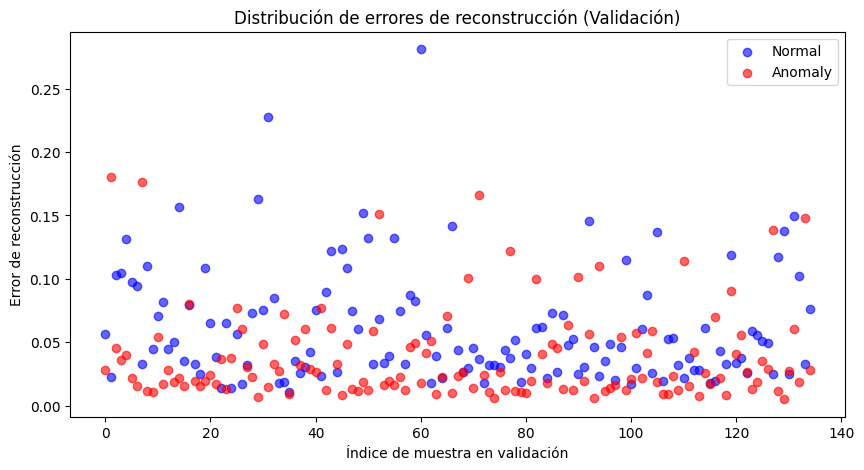

In [17]:
plt.figure(figsize=(10,5))
plt.scatter(np.arange(len(error_normal)),  error_normal,  label='Normal', color = 'Blue', marker='o', alpha=0.6)
plt.scatter(np.arange(len(error_anomaly)), error_anomaly, label='Anomaly', color = 'Red', marker='o', alpha=0.6)
plt.xlabel("Índice de muestra en validación")
plt.ylabel("Error de reconstrucción")
plt.title("Distribución de errores de reconstrucción (Validación)")
plt.legend()
plt.show()

#### Mejor **umbral** (maximizando accuracy)

In [18]:
thresholds = np.linspace(errors.min(), errors.max(), 100)
best_acc = 0
best_th = 0

for th in thresholds:
    preds = (errors > th).astype(int)  # 1 = anomalía
    acc = accuracy_score(labels, preds)
    if acc > best_acc:
        best_acc = acc
        best_th = th

print(f"\n🔍 Mejor umbral: {best_th:.4f} con accuracy: {best_acc:.4f}")



🔍 Mejor umbral: 0.1640 con accuracy: 0.5037


### **3. Con este umbral, calcular las prestaciones del detector de anomalías sobre el conjunto de test. Calcular también probabilidad de falsos positivos y de falsos negativos.**

#### **Evaluar** sobre conjunto de test

In [19]:

# Evaluar sobre conjunto de test
autoencoder.eval()
test_errors = []
test_labels = []

with torch.no_grad():
    for imgs, lbls in test_loader:
        imgs = imgs.to(device)
        outputs = autoencoder(imgs)
        loss = F.mse_loss(outputs, imgs, reduction='none')
        loss = loss.view(loss.size(0), -1).mean(dim=1)
        test_errors.extend(loss.cpu().numpy())
        test_labels.extend(lbls.numpy())

# Convertir a array
test_errors = np.array(test_errors).flatten()
test_labels = np.array(test_labels).flatten()

# Predicciones: 1 si el error supera el umbral (anomalía), 0 si no
test_preds = (test_errors > best_th).astype(int)

# Accuracy global
acc_test = accuracy_score(test_labels, test_preds)
print(f"✅ Accuracy en test: {acc_test:.4f}")


✅ Accuracy en test: 0.4872


#### **Matriz de confusión**

🚨 Tasa de falsos positivos (FP rate): 0.0299
⚠️ Tasa de falsos negativos (FN rate): 0.9957


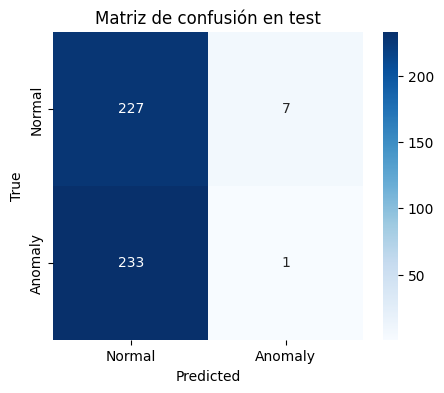

In [20]:
# Matriz de confusión
cm = confusion_matrix(test_labels, test_preds)
tn, fp, fn, tp = cm.ravel()

# Cálculo de tasas
fp_rate = fp / (fp + tn)
fn_rate = fn / (fn + tp)

print(f"🚨 Tasa de falsos positivos (FP rate): {fp_rate:.4f}")
print(f"⚠️ Tasa de falsos negativos (FN rate): {fn_rate:.4f}")

# Mostrar matriz de confusión
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Normal", "Anomaly"], yticklabels=["Normal", "Anomaly"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Matriz de confusión en test")
plt.show()

**¿Qué representan estas métricas?**
* **Accuracy**: qué porcentaje de imágenes fueron clasificadas correctamente.

* **FP Rate**: cuántos sanos fueron mal clasificados como enfermos.

* **FN Rate**: cuántos enfermos fueron mal clasificados como sanos (esto es grave en salud 🧑‍⚕️).

